# Coding Demonstration

In this document, we will show how our model works on the cardiovascular disease data set that contains standard health information and information on the presence/absence of cardiovascular disease for over 70,000 patients. Since the overarching objective of our project is to predict whether an individual is prone to get cardiovascular disease given his personal data, we would like to first determine the features and types of data (demographic, examination, and social history) that are most relevant for predicting disease and then to design a classifier to identify the presence of cardiovascular disease.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
url = "https://raw.githubusercontent.com/M-0-N-I-C-A/PIC16B_Project/main/cardio_train.csv"
df = pd.read_csv(url, sep = ';')

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Visualization

We would like to first develop a basic understanding of this dataset through the plots below. 

From the heatmap, we can get a sense of the degree to which different features are correlated. 

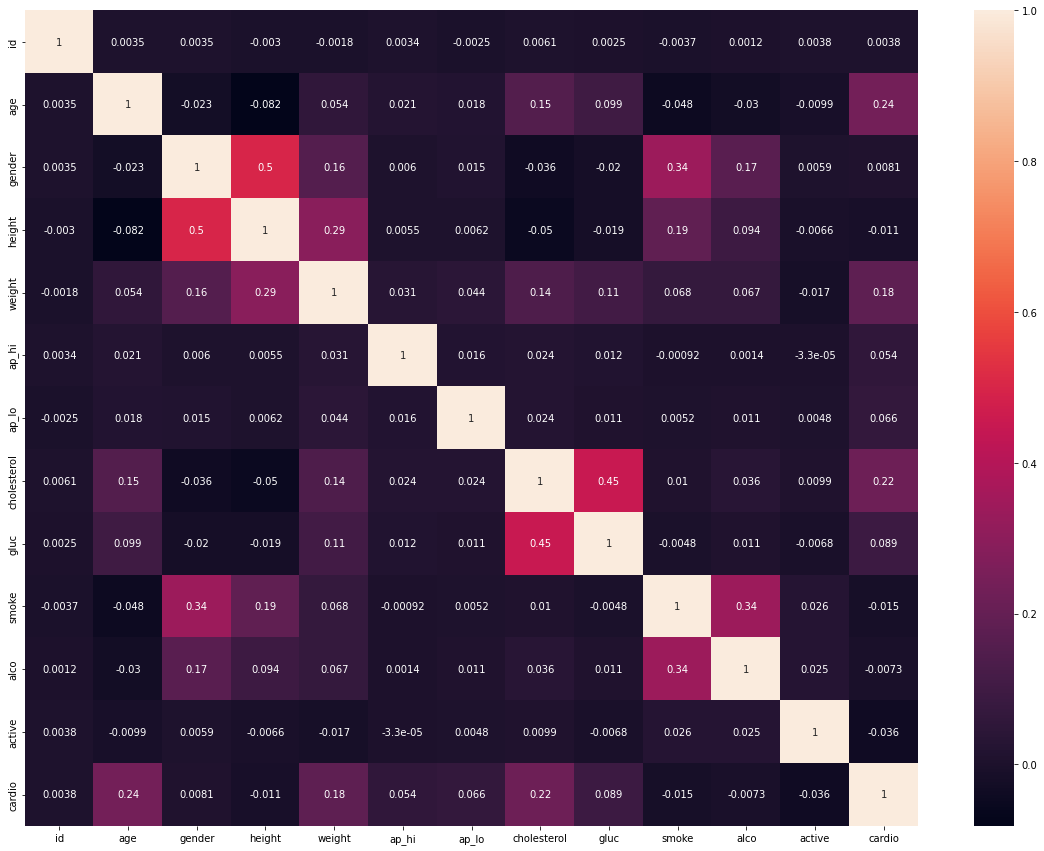

In [5]:
# check correlations
plt.subplots(figsize = (20, 15))
sns.heatmap(df.corr(), annot = True)

This heatmap shows correlations between variables in the dataset. We see that no features directly correlate with the label (cardio) and that generally, there do not exist significant correlations between other variables. However, correlations exist between a select few variables:

- Height and gender are correlated with a score of 0.5.
- Glucose and cholesterol are correlated with a score of 0.45.
- Smoking habits and gender are correlated with a score of 0.34.

From the box-whisker plots, we can check for outliers in each feature. 

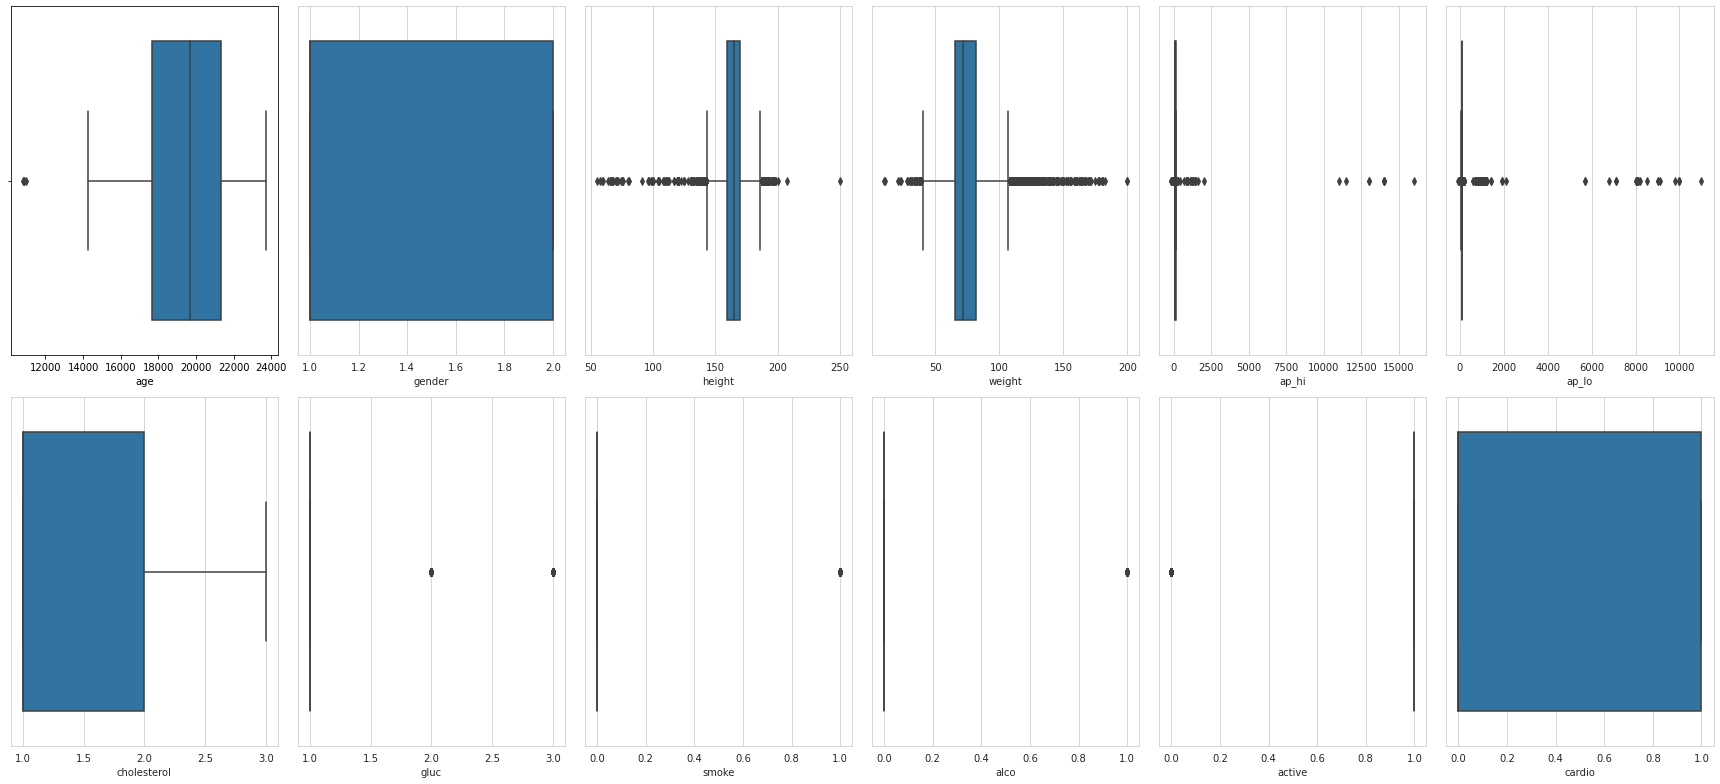

In [6]:
# check outliers
def check_outliers(df):
    l = df.columns.values
    number_of_columns = (len(l) - 1) / 2
    number_of_rows = 2
    
    plt.figure(figsize = (4 * number_of_columns, 8 * number_of_rows))
    for i in range(1, len(l)):
        plt.subplot(number_of_rows + 1, number_of_columns, i)
        sns.set_style('whitegrid')
        sns.boxplot(x = df[l[i]], orient = 'h')
        plt.tight_layout()


check_outliers(df)

The above boxplots show that there are indeed outliers in the dataset in the systolic and diastolic variables (ap_hi and ap_lo), which might be explained by human error when entering data into the .csv format. Removal of these outliers could potentially improve the prediction accuracy of our model.

From the histograms, we can further understand how the data for each feature is distributed.

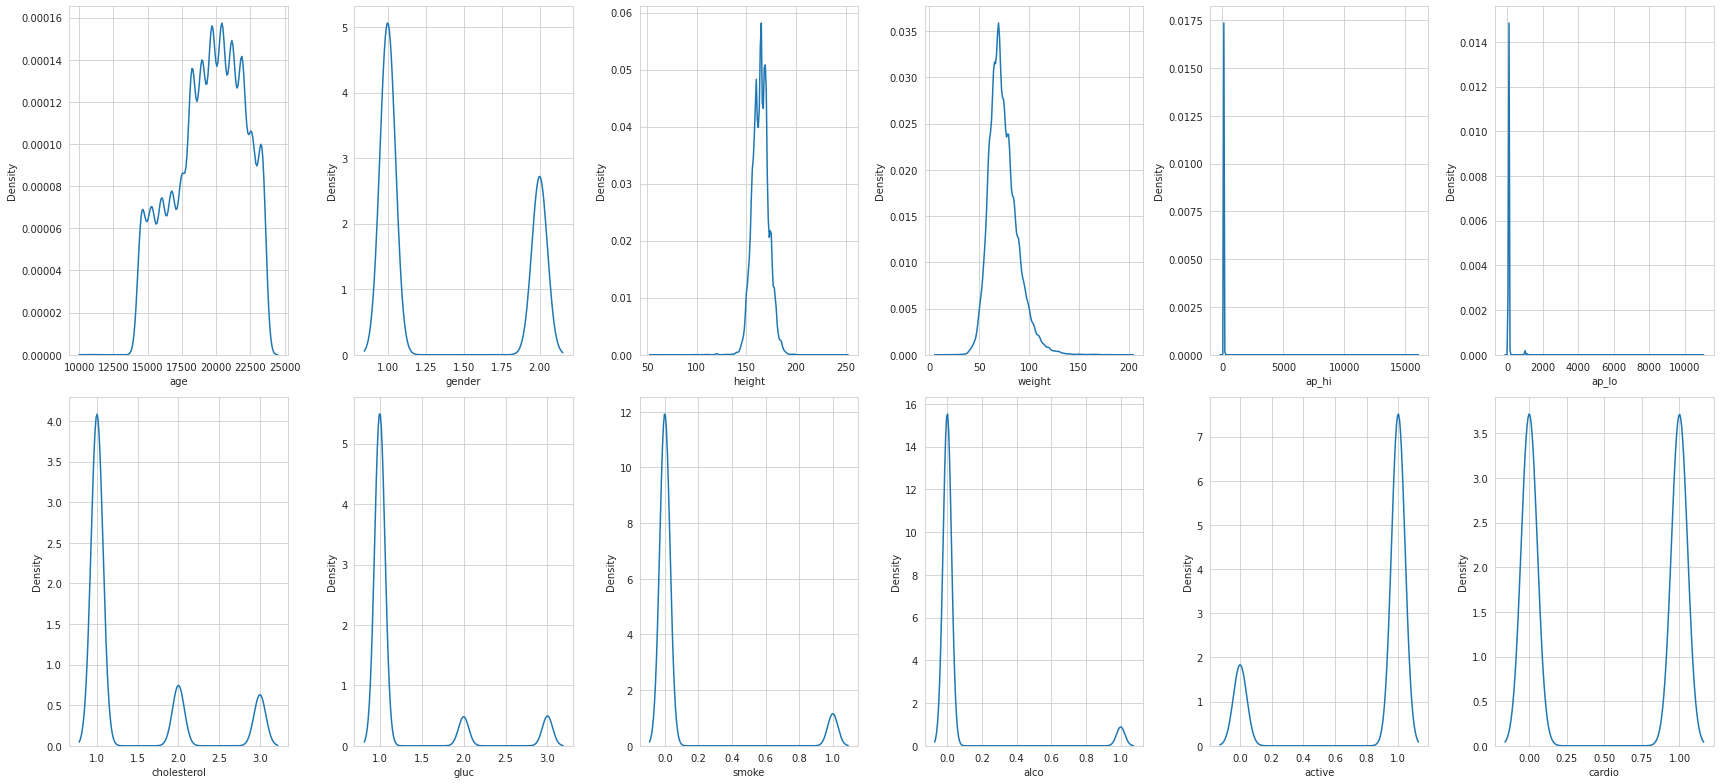

In [7]:
# check distribution and skew
def check_dist(df):
    l = df.columns.values
    number_of_columns = (len(l) - 1) / 2
    number_of_rows = 2
    
    plt.figure(figsize = (4 * number_of_columns, 8 * number_of_rows))
    for i in range(1, len(l)):
        plt.subplot(number_of_rows + 1, number_of_columns, i)
        sns.kdeplot(x = df[l[i]]) 
        plt.tight_layout()
        
check_dist(df)

The above histograms show that height and weight are roughly normally distributed while there are some variation in age. Moreover, the histograms further corroborate the presence of outliers in the blood pressure features. Also, there exist categorical features in the dataset, such as gender, cholesterol, glucose, smoking habits, alcohol use, and activity.

## Data Cleaning

We remove outliers in the systolic and diastolic variables (ap_hi and ap_lo) and check the data again using box-whisker plots and histograms.

In [8]:
df = df[df['ap_hi'] < 250]  
df = df[df['ap_lo'] < 250]

In [9]:
df.to_csv('clean_df.csv', index=False)

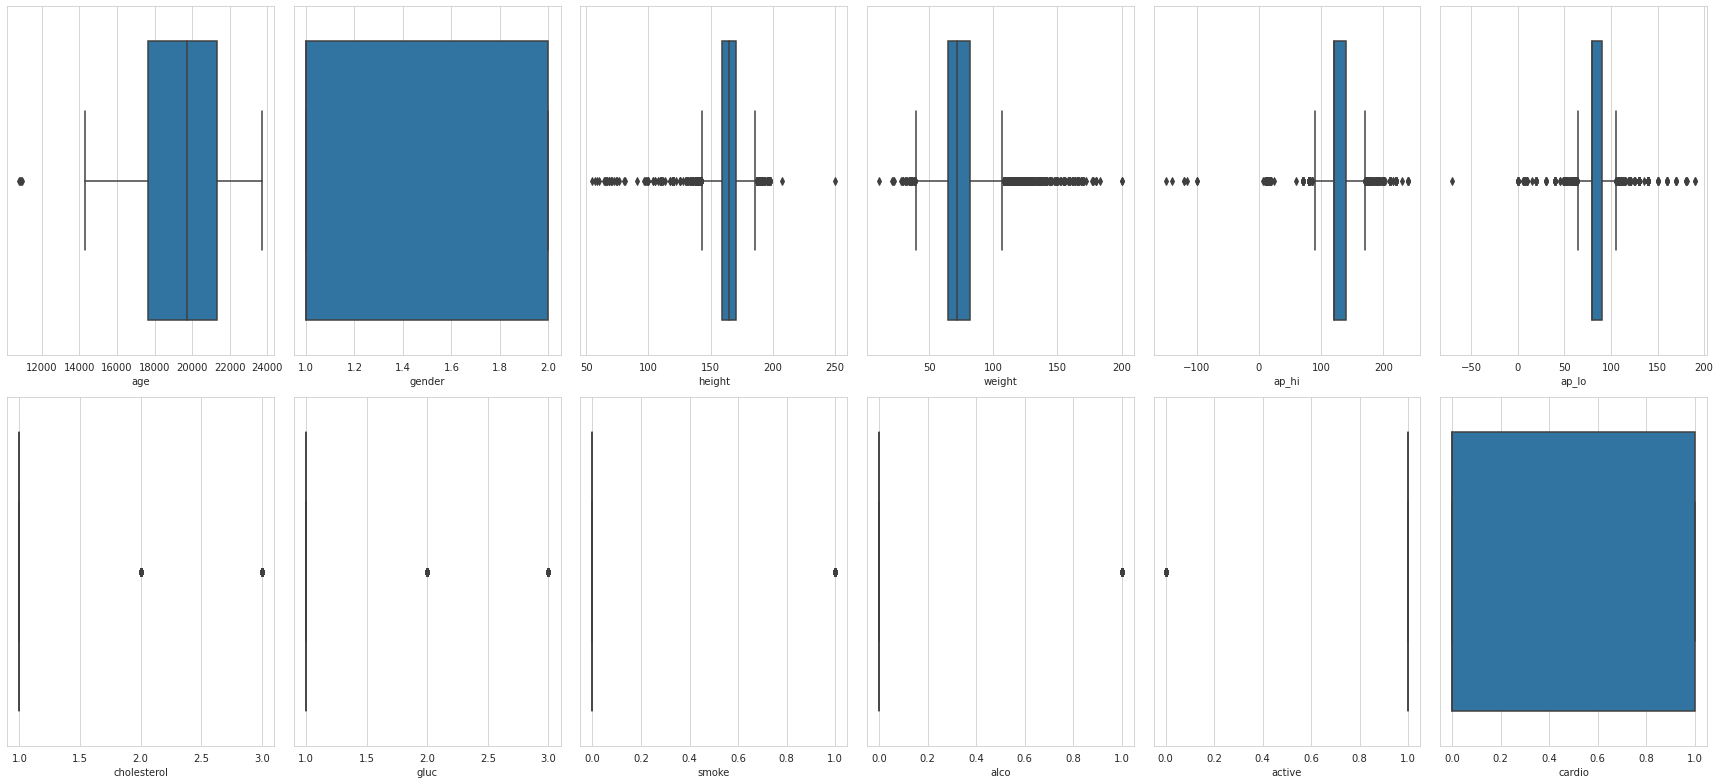

In [10]:
check_outliers(df)

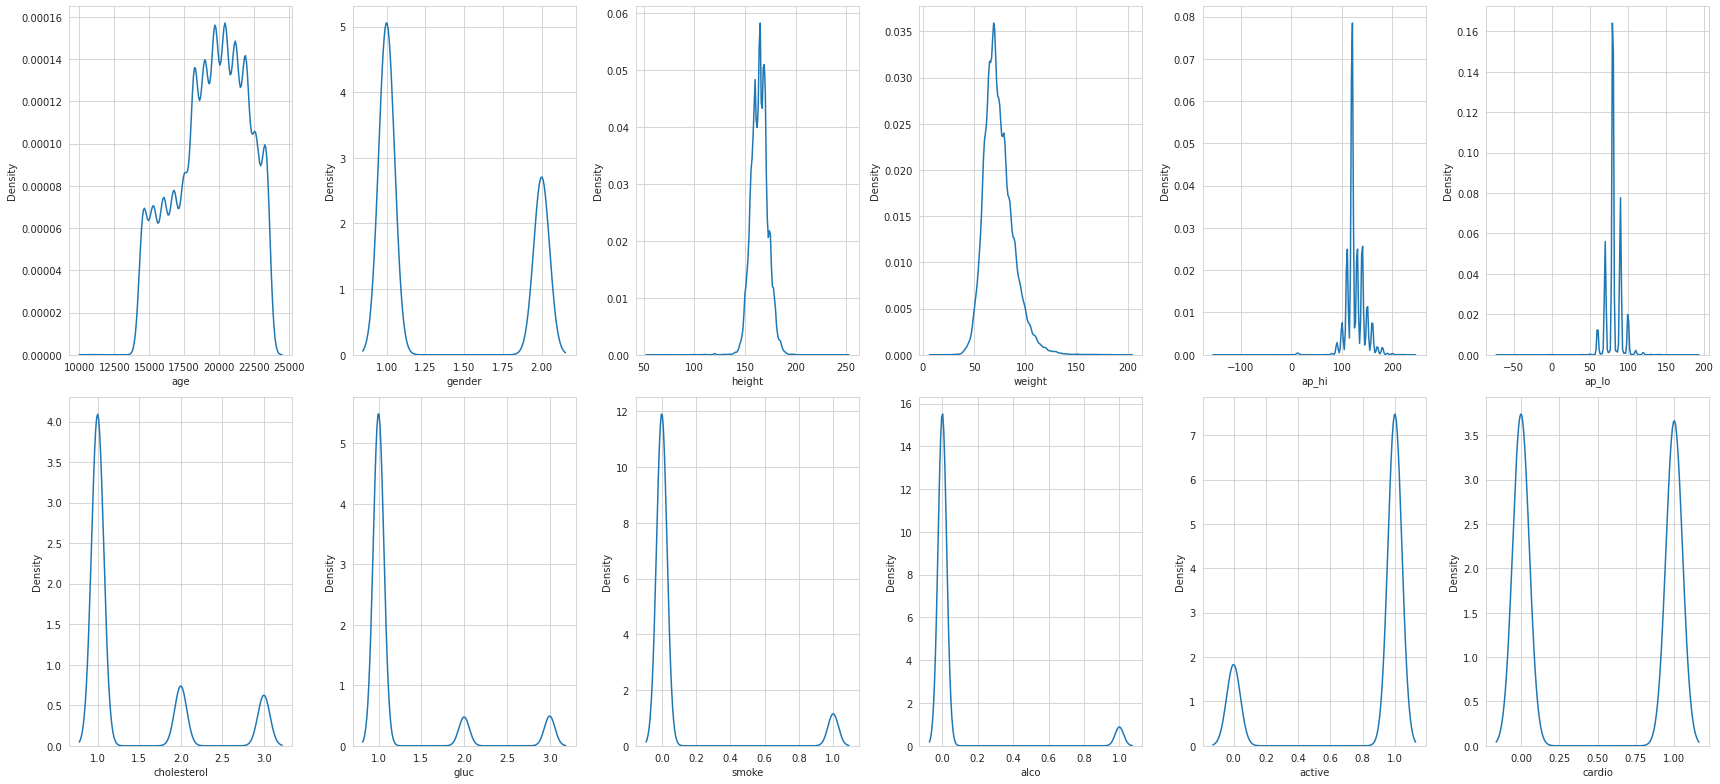

In [11]:
check_dist(df)

We can see from the above boxplots and histograms that the systolic and diastolic variables are much more regularly distributed after the removal of outliers, which allows the current data set to provide more meaningful input for our model.

In [ ]:
# convert the gender column
df["gender"] = df["gender"] - 1
# rescale the age column
df["age"] = df["age"] // 365
# drop the id column
df = df.drop(["id"], axis = 1)

In [ ]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,110,80,1,1,0,0,1,0
1,55,0,156,85.0,140,90,3,1,0,0,1,1
2,51,0,165,64.0,130,70,3,1,0,0,0,1
3,48,1,169,82.0,150,100,1,1,0,0,1,1
4,47,0,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df.to_csv('clean_df.csv', index=False)

# Machine learning

## Feature Selection 1 : Five Numerical Columns

We first split the cleaned data set into predictor data consisting of five variables and target data (cardio). Then we split the data set into training(70%) and testing sets(30%). We then deploy the Sequential model with multiple dense layers, compile the model, and trained it over 20 epochs. The training history is shown in the plot below. We can see that this 5-feature combination yielded a prediction accuracy at around 70%.

In [ ]:
from sklearn.model_selection import train_test_split
# predictor data
X = df[["age","height","weight","ap_hi","ap_lo"]]
# target data
y = df[["cardio"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
model = tf.keras.models.Sequential([
    layers.Dense(500, activation='relu',input_shape=(5,)),
    layers.Dense(500, activation='relu'),
    layers.Dense(2)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               3000      
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 2)                 1002      
                                                                 
Total params: 254,502
Trainable params: 254,502
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = "adam",
              loss = loss_fn,
              metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs = 20, verbose=1)

Epoch 1/20
1510/1510 [==============================] - 7s 4ms/step - loss: 0.8887 - accuracy: 0.6521
Epoch 2/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6036 - accuracy: 0.6837
Epoch 3/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5873 - accuracy: 0.6950
Epoch 4/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5826 - accuracy: 0.6996
Epoch 5/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5835 - accuracy: 0.6986
Epoch 6/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5830 - accuracy: 0.6985
Epoch 7/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5820 - accuracy: 0.6995
Epoch 8/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5807 - accuracy: 0.7024
Epoch 9/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5793 - accuracy: 0.7020
Epoch 10/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.578

[Text(0, 0.5, 'training accuracy'), Text(0.5, 0, 'epoch')]

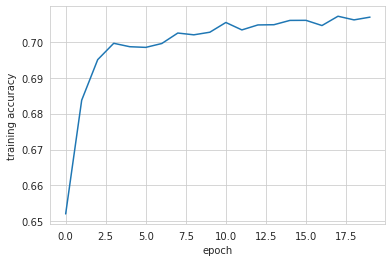

In [ ]:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

In [ ]:
model.evaluate(X_test, y_test, verbose = 2)

647/647 - 1s - loss: 0.5798 - accuracy: 0.7030 - 1s/epoch - 2ms/step


[0.5798428654670715, 0.7029898762702942]

In [ ]:
X_test.head(1)

,age,height,weight,ap_hi,ap_lo
44455,50,155,60.0,130,100


## Feature Selection 2 : Five Categorical Columns

We repeated the model construction, compilation and training process with a different combination of features. This time we choose to use five categorical variables as our predictor data, which yielded a prediction accuracy of roughly 59%.

In [ ]:
from sklearn.model_selection import train_test_split
# predictor data
X = df[["cholesterol","gluc","smoke","alco","active"]]
# target data
y = df[["cardio"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
model = tf.keras.models.Sequential([
    layers.Dense(500, activation='relu',input_shape=(5,)),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 500)               3000      
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 1002      
                                                                 
Total params: 254,502
Trainable params: 254,502
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = "adam",
              loss = loss_fn,
              metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs = 20, verbose=1)

Epoch 1/20
1510/1510 [==============================] - 7s 4ms/step - loss: 0.6681 - accuracy: 0.5887
Epoch 2/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6664 - accuracy: 0.5896
Epoch 3/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6659 - accuracy: 0.5917
Epoch 4/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6658 - accuracy: 0.5917
Epoch 5/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6654 - accuracy: 0.5923
Epoch 6/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6655 - accuracy: 0.5916
Epoch 7/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6656 - accuracy: 0.5909
Epoch 8/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6654 - accuracy: 0.5923
Epoch 9/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6654 - accuracy: 0.5910
Epoch 10/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.665

[Text(0, 0.5, 'training accuracy'), Text(0.5, 0, 'epoch')]

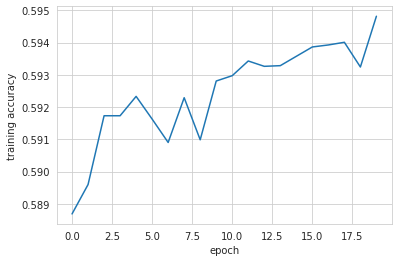

In [ ]:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

In [ ]:
model.evaluate(X_test, y_test, verbose = 2)

647/647 - 1s - loss: 0.6672 - accuracy: 0.5889 - 1s/epoch - 2ms/step


[0.6672240495681763, 0.5888518691062927]

## Feature Selection 3 : Five columns with highest correlation score (Heatmap)

The same modeling process also applies here. This time, we choose to use the five variables with the highest correlation scores to cardio as our predictor data and yielded a prediction accuracy of roughly 69%.

In [ ]:
from sklearn.model_selection import train_test_split
# predictor data
X = df[["cholesterol","gluc","age","weight","ap_lo"]]
# target data
y = df[["cardio"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
model = tf.keras.models.Sequential([
    layers.Dense(500, activation='relu',input_shape=(5,)),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2)
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 500)               3000      
                                                                 
 dense_7 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_8 (Dense)             (None, 2)                 1002      
                                                                 
Total params: 254,502
Trainable params: 254,502
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = "adam",
              loss = loss_fn,
              metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs = 20, verbose=1)

Epoch 1/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.7663 - accuracy: 0.5259
Epoch 2/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6838 - accuracy: 0.5501
Epoch 3/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6728 - accuracy: 0.5788
Epoch 4/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6646 - accuracy: 0.5976
Epoch 5/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6480 - accuracy: 0.6271
Epoch 6/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6210 - accuracy: 0.6632
Epoch 7/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6076 - accuracy: 0.6748
Epoch 8/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.6022 - accuracy: 0.6822
Epoch 9/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5999 - accuracy: 0.6844
Epoch 10/20
1510/1510 [==============================] - 6s 4ms/step - loss: 0.599

[Text(0, 0.5, 'training accuracy'), Text(0.5, 0, 'epoch')]

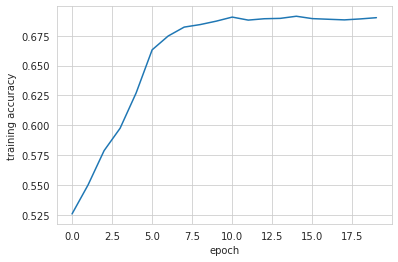

In [ ]:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

In [ ]:
model.evaluate(X_test, y_test, verbose = 2)

647/647 - 1s - loss: 0.6026 - accuracy: 0.6824 - 1s/epoch - 2ms/step


[0.6025764346122742, 0.6823648810386658]